Задание 1. Анализ NWOE и NIV для ATE
Цель: Оценить средний эффект воздействия (ATE) с помощью расчёта NWOE (Net Weight of Evidence) и NIV (Net Information Value) по признакам из A/B-тестов рекламной платформы Criteo. (http://ailab.criteo.com/criteo-uplift-prediction-dataset/)
Данные:
 Criteo Uplift Prediction (~13,9 млн записей, 11 анонимных признаков, treatment, visit/conversion).
Задачи:
1. Предобработка и EDA
2. Расчёт NWOE/NIV с использованием pylift
3. Интерпретация и визуализация результатов
4. TL;DR для руководства (бизнес-рекомендации)
5. Код + презентация (10–15 слайдов)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/Colab Notebooks/criteo-uplift-v2.1.csv"
df = pd.read_csv(path)
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
3,12.616365,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
4,12.616365,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0


In [ ]:
print(f"Размер датасета: {df.shape}")
print("\nИнформация о столбцах:")
print(df.info())
print("\nПропущенные значения:")
print(df.isnull().sum())

Размер датасета: (13979592, 16)

Информация о столбцах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13979592 entries, 0 to 13979591
Data columns (total 16 columns):
 #   Column      Dtype  
---  ------      -----  
 0   f0          float64
 1   f1          float64
 2   f2          float64
 3   f3          float64
 4   f4          float64
 5   f5          float64
 6   f6          float64
 7   f7          float64
 8   f8          float64
 9   f9          float64
 10  f10         float64
 11  f11         float64
 12  treatment   int64  
 13  conversion  int64  
 14  visit       int64  
 15  exposure    int64  
dtypes: float64(12), int64(4)
memory usage: 1.7 GB
None

Пропущенные значения:
f0            0
f1            0
f2            0
f3            0
f4            0
f5            0
f6            0
f7            0
f8            0
f9            0
f10           0
f11           0
treatment     0
conversion    0
visit         0
exposure      0
dtype: int64


In [ ]:
print("1. Базовые статистики:")
display(round(df.describe(),2))

print("\nРаспределение по группам:")
display(df['treatment'].value_counts(normalize=True).to_frame())

print("\nКонверсия по группам:")
display(df.groupby('treatment')['conversion'].mean().to_frame())

1. Базовые статистики:


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
count,13979592.00,13979592.00,13979592.00,13979592.00,13979592.00,13979592.00,13979592.00,13979592.00,13979592.00,13979592.00,13979592.00,13979592.00,13979592.00,13979592.00,13979592.00,13979592.00
mean,19.62,10.07,8.45,4.18,10.34,4.03,-4.16,5.10,3.93,16.03,5.33,-0.17,0.85,0.00,0.05,0.03
std,5.38,0.10,0.30,1.34,0.34,0.43,4.58,1.21,0.06,7.02,0.17,0.02,0.36,0.05,0.21,0.17
min,12.62,10.06,8.21,-8.40,10.28,-9.01,-31.43,4.83,3.64,13.19,5.30,-1.38,0.00,0.00,0.00,0.00
25%,12.62,10.06,8.21,4.68,10.28,4.12,-6.70,4.83,3.91,13.19,5.30,-0.17,1.00,0.00,0.00,0.00
50%,21.92,10.06,8.21,4.68,10.28,4.12,-2.41,4.83,3.97,13.19,5.30,-0.17,1.00,0.00,0.00,0.00
75%,24.44,10.06,8.72,4.68,10.28,4.12,0.29,4.83,3.97,13.19,5.30,-0.17,1.00,0.00,0.00,0.00
max,26.75,16.34,9.05,4.68,21.12,4.12,0.29,12.00,3.97,75.30,6.47,-0.17,1.00,1.00,1.00,1.00



Распределение по группам:


,proportion
treatment,
1,0.85
0,0.15



Конверсия по группам:


,conversion
treatment,
0,0.001938
1,0.003089


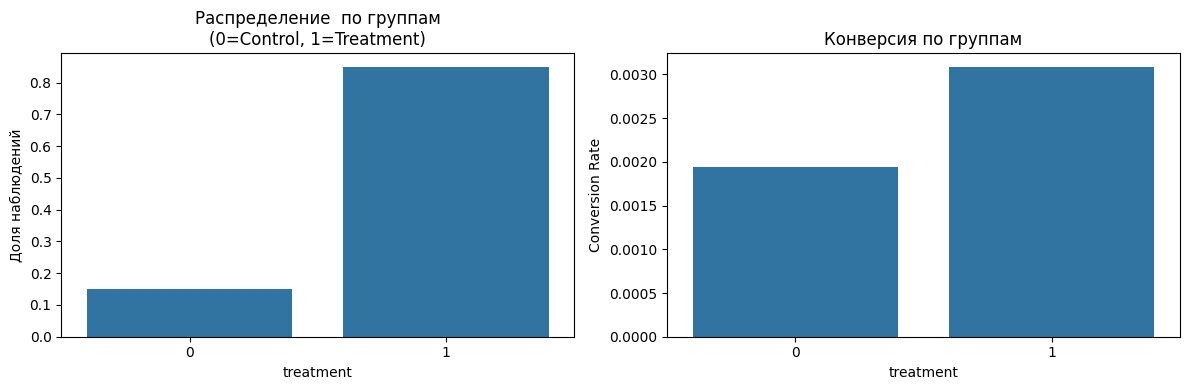

In [ ]:
#Визуализация распределения treatment и conversion
plt.figure(figsize=(12, 4))

# График распределения treatment
plt.subplot(1, 2, 1)
treatment_counts = df['treatment'].value_counts(normalize=True)
sns.barplot(x=treatment_counts.index, y=treatment_counts.values)
plt.title('Распределение  по группам\n(0=Control, 1=Treatment)')
plt.ylabel('Доля наблюдений')

# График конверсии по группам
plt.subplot(1, 2, 2)
conversion_rates = df.groupby('treatment')['conversion'].mean()
sns.barplot(x=conversion_rates.index, y=conversion_rates.values)
plt.title('Конверсия по группам')
plt.ylabel('Conversion Rate')

plt.tight_layout()
plt.show()

Корреляционный анализ:


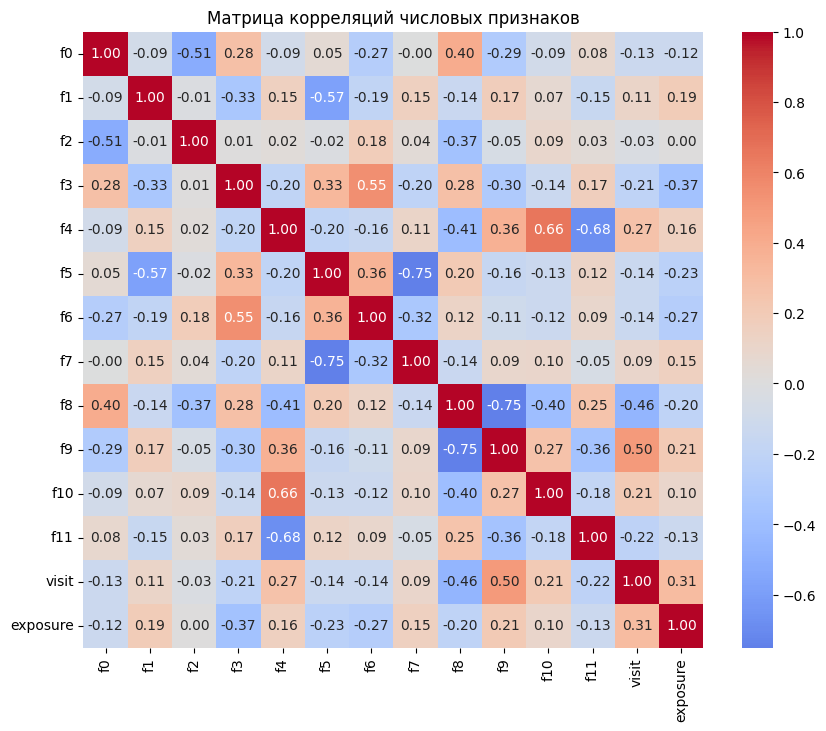

In [ ]:
# Корреляционный анализ
print("Корреляционный анализ:")
numeric_cols = df.select_dtypes(include=['number']).columns
numeric_cols = [col for col in numeric_cols if col not in ['treatment', 'conversion']]

if len(numeric_cols) > 1:
    plt.figure(figsize=(10, 8))
    corr = df[numeric_cols].corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
    plt.title('Матрица корреляций числовых признаков')
    plt.show()
else:
    print("Недостаточно числовых признаков для корреляционного анализа")

In [ ]:
stats_list = []
for col in numeric_cols:
    # Вычисляем основные статистики
    stats = df[col].describe().to_dict()
    stats['feature'] = col
    stats['skewness'] = df[col].skew()  # Коэффициент асимметрии
    stats['kurtosis'] = df[col].kurt()  # Коэффициент эксцесса
    stats_list.append(stats)

stats_df = pd.DataFrame(stats_list)
stats_df = stats_df[['feature', 'count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'skewness', 'kurtosis']]
stats_df = stats_df.rename(columns={
    'feature': 'Признак',
    'count': 'Кол-во',
    'mean': 'Среднее',
    'std': 'Ст.откл.',
    'min': 'Минимум',
    '25%': '25-й перцентиль',
    '50%': 'Медиана',
    '75%': '75-й перцентиль',
    'max': 'Максимум',
    'skewness': 'Асимметрия',
    'kurtosis': 'Эксцесс'
})

display(stats_df)

,Признак,Кол-во,Среднее,Ст.откл.,Минимум,25-й перцентиль,Медиана,75-й перцентиль,Максимум,Асимметрия,Эксцесс
0,f0,13979592.0,19.620297,5.377464,12.616365,12.616365,21.923413,24.436459,26.745255,-0.245828,-1.626658
1,f1,13979592.0,10.069977,0.104756,10.059654,10.059654,10.059654,10.059654,16.344187,13.997755,267.553837
2,f2,13979592.0,8.446582,0.299316,8.214383,8.214383,8.214383,8.723335,9.051962,0.806385,-1.008584
3,f3,13979592.0,4.178923,1.336645,-8.398387,4.679882,4.679882,4.679882,4.679882,-3.186468,10.514233
4,f4,13979592.0,10.338837,0.343308,10.280525,10.280525,10.280525,10.280525,21.123508,8.882763,104.134838
5,f5,13979592.0,4.028513,0.431097,-9.011892,4.115453,4.115453,4.115453,4.115453,-7.085842,68.820385
6,f6,13979592.0,-4.155356,4.577914,-31.429784,-6.699321,-2.411115,0.294443,0.294443,-1.135889,0.773958
7,f7,13979592.0,5.101765,1.205248,4.833815,4.833815,4.833815,4.833815,11.998401,4.524972,19.223019
8,f8,13979592.0,3.933581,0.056660,3.635107,3.910792,3.971858,3.971858,3.971858,-1.605565,1.853788
9,f9,13979592.0,16.027638,7.018975,13.190056,13.190056,13.190056,13.190056,75.295017,2.822741,7.726637


In [ ]:
def calculate_metrics(df):
    results = {}
    results['ATE'] = df[df['treatment']==1]['conversion'].mean() - df[df['treatment']==0]['conversion'].mean()
    def calc_nwoe(feature):
        try:
            temp_df = df.copy()
            if pd.api.types.is_numeric_dtype(temp_df[feature]):
                temp_df[feature+'_bin'] = pd.qcut(temp_df[feature], q=5, duplicates='drop')
                feature = feature+'_bin'
            treated = temp_df[temp_df['treatment']==1].groupby(feature, observed=True)['conversion'].agg(['mean', 'count'])
            control = temp_df[temp_df['treatment']==0].groupby(feature, observed=True)['conversion'].agg(['mean', 'count'])

            eps = 1e-10
            treated['woe'] = np.log((treated['mean']+eps)/(1-treated['mean']+eps)) - \
                            np.log((control['mean']+eps)/(1-control['mean']+eps))

            return (treated['woe'] * treated['count']).sum() / treated['count'].sum()
        except Exception as e:
            print(f"NWOE error for {feature}: {str(e)}")
            return None

    def calc_niv(feature):
        try:
            temp_df = df.copy()
            if pd.api.types.is_numeric_dtype(temp_df[feature]):
                temp_df[feature+'_bin'] = pd.qcut(temp_df[feature], q=5, duplicates='drop')
                feature = feature+'_bin'
            treated = temp_df[temp_df['treatment']==1].groupby(feature, observed=True)['conversion'].mean()
            control = temp_df[temp_df['treatment']==0].groupby(feature, observed=True)['conversion'].mean()
            eps = 1e-10
            return ((treated - control) * np.log((treated+eps)/(control+eps))).sum()
        except Exception as e:
            print(f"NIV error for {feature}: {str(e)}")
            return None
    features = [f'f{i}' for i in range(12) if f'f{i}' in df.columns]
    metrics = pd.DataFrame(index=features, columns=['NWOE', 'NIV'])

    for feature in features:
        metrics.loc[feature, 'NWOE'] = calc_nwoe(feature)
        metrics.loc[feature, 'NIV'] = calc_niv(feature)

    results['metrics'] = metrics.dropna()
    return results

In [ ]:
results = calculate_metrics(df)
print("Average Treatment Effect:", results['ATE'])
print("\nTop Features by NWOE:")
print(results['metrics'].sort_values('NWOE', ascending=False).head(5))
print("\nTop Features by NIV:")
print(results['metrics'].sort_values('NIV', ascending=False).head(5))

Average Treatment Effect: 0.0011518730521316279

Top Features by NWOE:
        NWOE       NIV
f9  0.503251  0.002385
f8  0.474687  0.002225
f1  0.467708  0.000537
f3  0.467708  0.000537
f4  0.467708  0.000537

Top Features by NIV:
        NWOE       NIV
f6  0.347674  0.002417
f9  0.503251  0.002385
f8  0.474687  0.002225
f0  0.373769  0.001539
f2  0.458189  0.001525


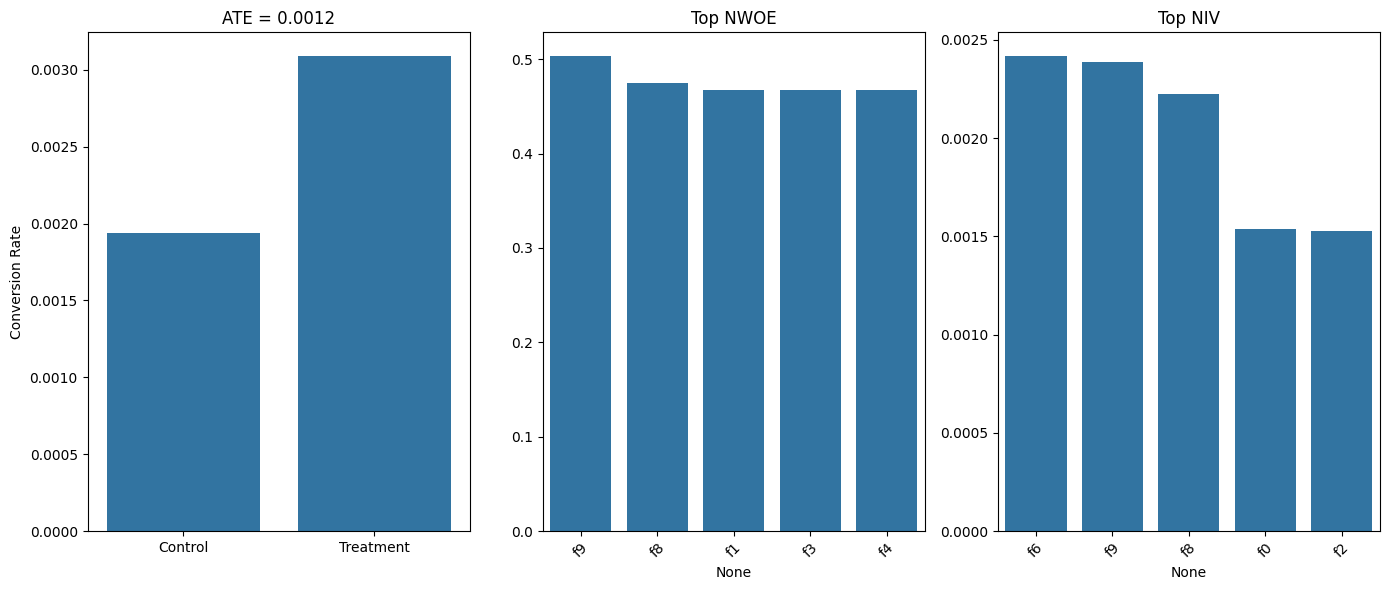

In [ ]:
plt.figure(figsize=(14, 6))

# 1. График ATE
plt.subplot(1, 3, 1)
sns.barplot(x=['Control', 'Treatment'],
            y=[df[df['treatment']==0]['conversion'].mean(),
               df[df['treatment']==1]['conversion'].mean()])
plt.title(f'ATE = {results["ATE"]:.4f}')
plt.ylabel('Conversion Rate')

# 2. Топ NWOE
plt.subplot(1, 3, 2)
top_nwoe = results['metrics']['NWOE'].abs().sort_values(ascending=False).head(5)
sns.barplot(x=top_nwoe.index, y=top_nwoe.values)
plt.title('Top NWOE')
plt.xticks(rotation=45)

# 3. Топ NIV
plt.subplot(1, 3, 3)
top_niv = results['metrics']['NIV'].abs().sort_values(ascending=False).head(5)
sns.barplot(x=top_niv.index, y=top_niv.values)
plt.title('Top NIV')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()